# ImageRetrieval AutoEncoders

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/Image_Retrieval
!ls 

/content/drive/MyDrive/Image_Retrieval
ImageRetrieval_CNN_BN.ipynb  lfw_attributes.txt    __pycache__
ImageRetrieval_CNN.ipynb     lfw_dataset.py	   tqdm_utils.py
ImageRetrieval_RESNET.ipynb  lfw-deepfunneled.tgz
keras_utils.py		     lfw.tgz


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import save_model
import tensorflow.keras.layers as L
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

import numpy as np
from sklearn.model_selection import train_test_split
from lfw_dataset import load_lfw_dataset
import matplotlib.pyplot as plt

# Load dataset
Dataset downloaded for you. Relevant links (just in case):
- http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
- http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
- http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [ ]:
# load images
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)
IMG_SHAPE = X.shape[1:]

# center images
X = X.astype('float32') / 255.0 - 0.5

# split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

**************************************************



In [ ]:
def show_image(img):
    plt.imshow(np.clip(img + 0.5, 0, 1))

<ipython-input-57-dde2a29b3ce3>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,i+1)


X shape: (13143, 32, 32, 3)
attr shape: (13143, 73)


24958

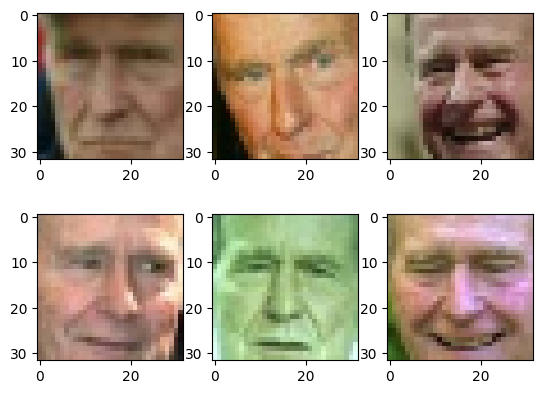

In [ ]:
plt.title('sample images')

for i in range(6):
    plt.subplot(2,3,i+1)
    show_image(X[i])

print("X shape:", X.shape)
print("attr shape:", attr.shape)

# try to free memory
import gc
gc.collect()

# ResNet50V2

pretrained ResNet50V2 as encoder

In [ ]:
# define the model using ResNet50V2
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy')

# train the model
model.fit(X_train, np.ones(len(X_train)), epochs=25, batch_size=32, validation_data=(X_test, np.ones(len(X_test))))


Epoch 1/25
370/370 [==============================] - 71s 181ms/step - loss: 0.0432 - val_loss: 0.0027
Epoch 2/25
370/370 [==============================] - 58s 157ms/step - loss: 0.0014 - val_loss: 7.7972e-04
Epoch 3/25
370/370 [==============================] - 59s 159ms/step - loss: 4.8067e-04 - val_loss: 3.5427e-04
Epoch 4/25
370/370 [==============================] - 58s 157ms/step - loss: 2.4224e-04 - val_loss: 1.9819e-04
Epoch 5/25
370/370 [==============================] - 59s 159ms/step - loss: 1.4287e-04 - val_loss: 1.2369e-04
Epoch 6/25
370/370 [==============================] - 64s 172ms/step - loss: 9.2138e-05 - val_loss: 8.2609e-05
Epoch 7/25
370/370 [==============================] - 59s 160ms/step - loss: 6.2934e-05 - val_loss: 5.7862e-05
Epoch 8/25
370/370 [==============================] - 58s 158ms/step - loss: 4.4742e-05 - val_loss: 4.1808e-05
Epoch 9/25
370/370 [==============================] - 58s 158ms/step - loss: 3.2727e-05 - val_loss: 3.0854e-05
Epoch 10/25
3

# Image retrieval with KNN

In [ ]:
# extract feature vectors
X_feats = base_model.predict(X_train)
num_images = X_feats.shape[0]
feat_dim = np.prod(X_feats.shape[1:])
X_feats = X_feats.reshape(num_images, feat_dim)

370/370 [==============================] - 49s 131ms/step


### Testing with KNN

In [ ]:
# fit KNN model
k = 3
nn_model = NearestNeighbors(n_neighbors=k, metric='cosine')
nn_model.fit(X_feats)


1/1 [==============================] - 0s 50ms/step


In [ ]:
def find_similar(image):
    query_feat = base_model.predict(query.reshape(1, 32, 32, 3))[0]
    query_feat = query_feat.flatten() # flatten the feature map

    # retrieve top k images
    distances, indices = nn_model.kneighbors(query_feat.reshape(1, -1))
    top_k_indices = indices[0]
    top_k_images = X[top_k_indices]
    
    # display query and retrieved images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, k+1, 1)
    plt.imshow(np.clip(query + 0.5, 0, 1))
    plt.axis('off')
    plt.title('query')

    for i in range(k):
        plt.subplot(1, k+1, i+2)
        plt.imshow(np.clip(top_k_images[i] + 0.5, 0, 1))
        plt.axis('off')
        plt.title('rank {}'.format(i+1))

    plt.show()

1/1 [==============================] - 0s 41ms/step


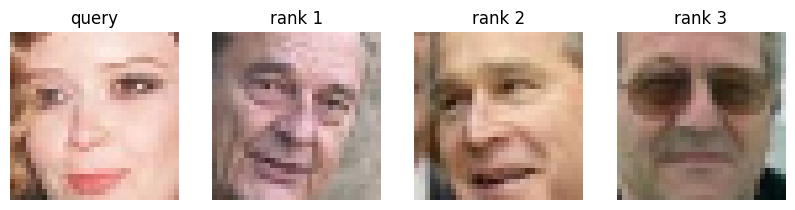

In [ ]:
# query a random image from the test set
query_index = np.random.choice(len(X_test))
query = X_test[query_index]
find_similar(query)